In [17]:
import numpy as np
import matplotlib.pyplot as plt

# MDP


Optimal policy:
{'Rainy': 'Umbrella', 'Cloudy': 'Umbrella', 'Sunny': 'No Umbrella'}


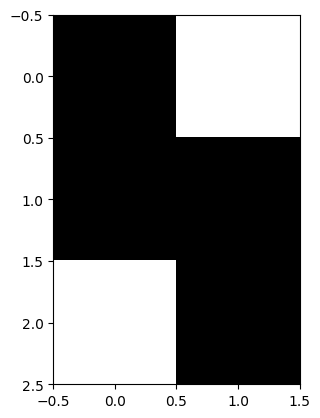

In [18]:

#Problem Statement: You're going out, do you need umbrella.

#States: Rainy, Cloudy and Sunny
#Actions: Umbrella & No umbrella
#Reward: Dict mapping with each state action pair
#Transition Prob
#Discount Factor
# Define the MDP parameters
states = ['Rainy', 'Cloudy', 'Sunny']
actions = ['Umbrella', 'No Umbrella']
rewards = {'Rainy': {'Umbrella': -1, 'No Umbrella': -5},
           'Cloudy': {'Umbrella': -1, 'No Umbrella': -1},
           'Sunny': {'Umbrella': -5, 'No Umbrella': -1}}
transitions = {'Rainy': {'Umbrella': {'Rainy': 0.7, 'Cloudy': 0.3, 'Sunny': 0},
                         'No Umbrella': {'Rainy': 0.3, 'Cloudy': 0.4, 'Sunny': 0.3}},
               'Cloudy': {'Umbrella': {'Rainy': 0.4, 'Cloudy': 0.6, 'Sunny': 0},
                          'No Umbrella': {'Rainy': 0, 'Cloudy': 0.7, 'Sunny': 0.3}},
               'Sunny': {'Umbrella': {'Rainy': 0, 'Cloudy': 0, 'Sunny': 1},
                         'No Umbrella': {'Rainy': 0, 'Cloudy': 0.4, 'Sunny': 0.6}}}
discount_factor = 0.9

#Fn for value iter
def value_iteration():
    #init, the value fn for each state to 0 
    V = {s: 0 for s in states}
    while True:
        #compute the updated value fn for each state
        new_V = {}
        for s in states:
            values = []
            for a in actions:
                value = rewards[s][a]
                for s2 in states:
                    value += discount_factor * transitions[s][a][s2] * V[s2]
                values.append(value)
            new_V[s] = max(values)
        # Check convergence
        if all(abs(V[s] - new_V[s]) < 0.0001 for s in states):
            return new_V
        V = new_V
V = value_iteration()

#compute optimal policy
policy = {}
for s in states:
    values = []
    for a in actions:
        value = rewards[s][a]
        for s2 in states:
            value += discount_factor * transitions[s][a][s2] * V[s2]
        values.append(value)
    policy[s] = actions[np.argmax(values)]

print("Optimal policy:")
print(policy)

# Plot
policy_values = np.zeros((len(states), len(actions)))
for i, s in enumerate(states):
    for j, a in enumerate(actions):
        policy_values[i, j] = rewards[s][a] + discount_factor * sum(transitions[s][a][s2] * V[s2] for s2 in states)
plt.imshow(policy_values, cmap='Greys')


 

# Bellman Equation

In [26]:
def reward(state, action):
    if state==0 and state == 1:
        return 1
    elif state == 3 and action ==1:
        return 2
    else:
        return 0
    
    
def transition_prob(state, action, next_state):
    if state==0 and action == 1 and next_state==1:
        return 1
    elif state == 3 and action == 0 and next_state ==2:
        return 1
    elif state == next_state:
        return 0.25
    else:
        return 0

[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  2.5]]


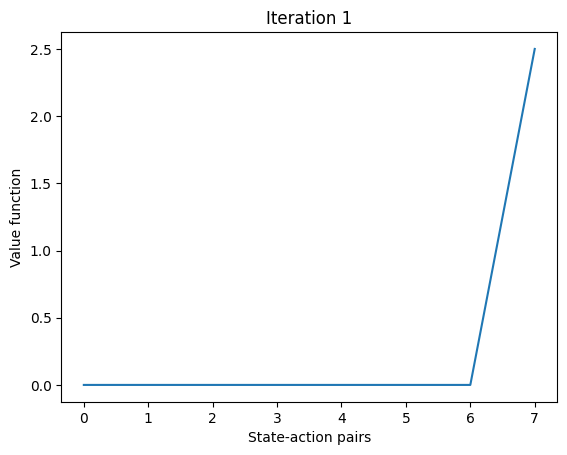

[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [1.125 3.625]]


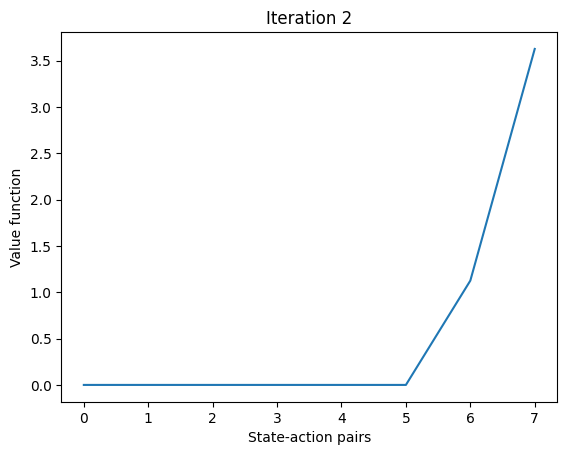

[[0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [1.63125 4.13125]]


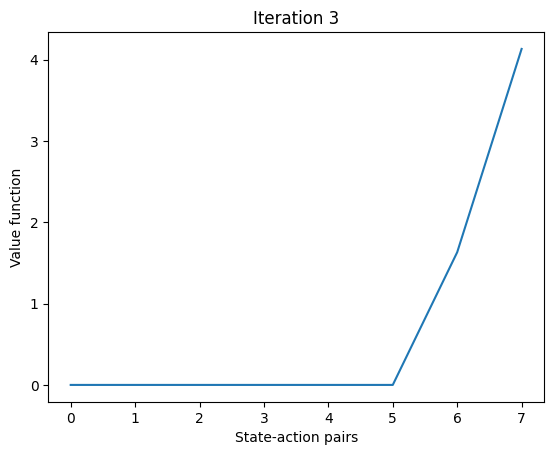

[[0.        0.       ]
 [0.        0.       ]
 [0.        0.       ]
 [1.8590625 4.3590625]]


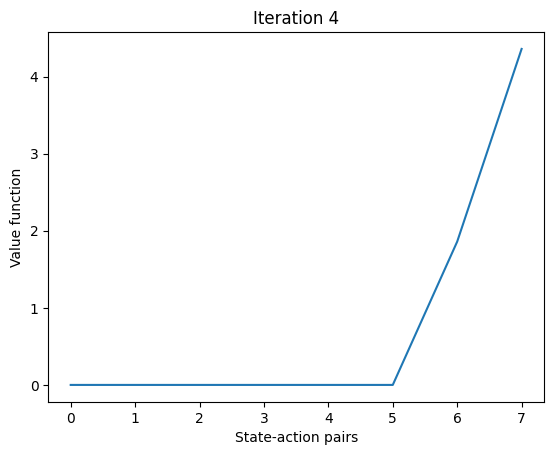

[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [1.96157813 4.46157812]]


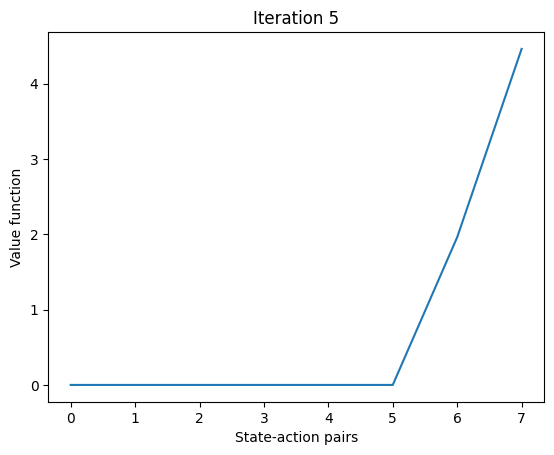

Optimal Value Function:
 [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [1.96157813 4.46157812]]


In [25]:

def bellman_eqn(value, gamma):
    new_value = np.zeros_like(value)
    for state in range(value.shape[0]):
        for action in range(value.shape[1]):
            action_value = 0
            for next_state in range(value.shape[0]):
                action_value += transition_prob(state, action, next_state) * (reward(state, action) + gamma * value[next_state, :].max())
            new_value[state, action] = action_value
    return new_value

def main():
    #value fn
    value = np.zeros((4,2))
    gamma = 0.9
    
    # Compute optimal value function
    for i in range(5):
        value = bellman_eqn(value, gamma)
        print(value)

        # Plot the value function after each iteration
        plt.plot(value.flatten())
        plt.xlabel('State-action pairs')
        plt.ylabel('Value function')
        plt.title(f'Iteration {i+1}')
        plt.show()

    # Print optimal value function
    print('Optimal Value Function:\n', value)
    
#     #Compute optimal val function
#     for i in range(5):
#         value = bellman_eqn(value, gamma)
    
#     #print optimal val fn
#     print('Optimal Value Function ', value)
if __name__ == "__main__":
    main()

# Q-Learning

In [27]:
#rewards
rewards = np.array([[-1,0,0,10],
                  [-1,0,0,10],
                   [-1,0,0,10],
                   [-1,0,0,0]
                   ])

#transition
transitions = np.array([
    [[0.5, 0.5,0,0], [0.5, 0,0.5,0], [0, 0.5,0,0.5], [0, 0,1,0]],
    [[0, 1,0,0], [1, 0, 0 , 0], [0, 0 , 0.5, 0.5], [0,0,1,0]],
    [[0, 0, 0.5, 0.5], [0, 0.5,0, 0.5], [0, 0.5,0, 0.5], [0,0,1,0]],
    [[0,0,0,1], [0, 0, 0.5, 0.5], [0, 0.5, 0, 0.5], [0.5, 0.5, 0, 0]],
])

In [29]:
#Q learning algorithm
def q_learning(transitions, rewards, gamma, alpha, epsilon, n_episodes):
    n_states, n_actions, _ = transitions.shape
    q_table = np.zeros((n_states, n_actions))
    
    total_rewards = []
    for episode in range(n_episodes):
        state = 0
        done = False
        total_reward = 0
        while not done:
            if np.random.rand()<epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(q_table[state])
            new_state = np.random.choice(np.arange(n_states), p=transitions[state, action]/np.sum(transitions[state, action]))
            reward = rewards[state, action]
            q_table[state, action] += alpha * (reward + gamma * np.max(q_table[new_state]) - q_table[state, action])
            state = new_state
            total_reward += reward
            if state==n_states-1:
                done = True
        total_rewards.append(total_reward)
    plt.plot(total_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.show()
    
    return q_table

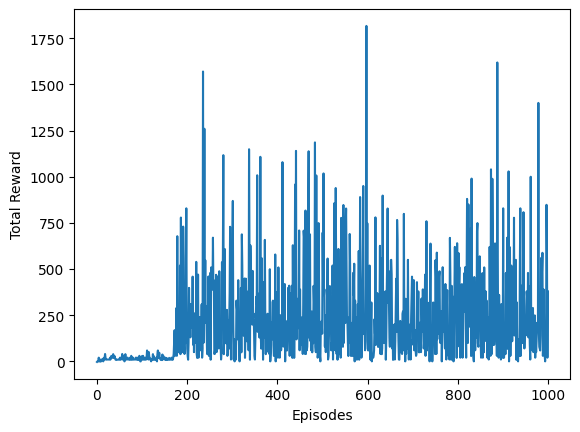

Converged Q Value [[ 88.99999064  89.99998007   0.75947065 100.        ]
 [ 88.99996387  89.9795882   62.07073848 100.        ]
 [ 80.84032309  55.5408242   17.50728518 100.        ]
 [  0.           0.           0.           0.        ]]


In [30]:

gamma = 0.9
alpha = 0.5
epsilon = 0.1
n_episodes = 1000
q_table = q_learning(transitions, rewards, gamma, alpha, epsilon, n_episodes)


#Print
print("Converged Q Value ", q_table)

# Q-Learning with TD


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def q_learning(transitions, rewards, gamma, alpha, epsilon, n_episodes):
    n_states, n_actions, _ = transitions.shape
    q_table = np.zeros((n_states, n_actions))
    
    total_rewards = []
    for episode in range(n_episodes):
        state = 0
        done = False
        total_reward = 0
        while not done:
            if np.random.rand()<epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(q_table[state])
            new_state = np.random.choice(np.arange(n_states), p=transitions[state, action]/np.sum(transitions[state, action]))
            reward = rewards[state, action]
            td_target = reward + gamma * np.max(q_table[new_state])
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error
            state = new_state
            total_reward += reward
            if state == n_states-1:
                done = True
        total_rewards.append(total_reward)
    
    plt.plot(total_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.show()
    
    return q_table


In [3]:
#rewards
rewards = np.array([[-1,0,0,10],
                  [-1,0,0,10],
                   [-1,0,0,10],
                   [-1,0,0,0]
                   ])

#transition
transitions = np.array([
    [[0.5, 0.5,0,0], [0.5, 0,0.5,0], [0, 0.5,0,0.5], [0, 0,1,0]],
    [[0, 1,0,0], [1, 0, 0 , 0], [0, 0 , 0.5, 0.5], [0,0,1,0]],
    [[0, 0, 0.5, 0.5], [0, 0.5,0, 0.5], [0, 0.5,0, 0.5], [0,0,1,0]],
    [[0,0,0,1], [0, 0, 0.5, 0.5], [0, 0.5, 0, 0.5], [0.5, 0.5, 0, 0]],
])

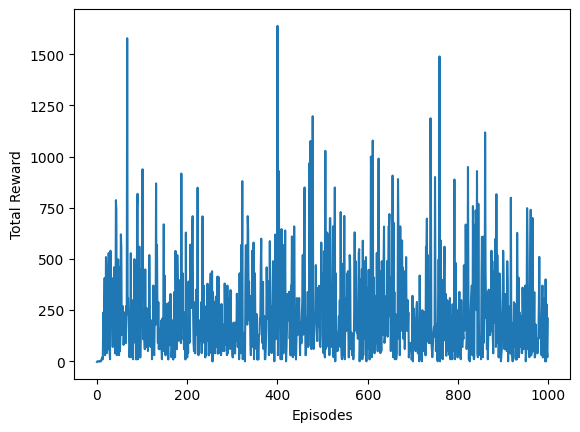

Converged Q Value  [[ 88.99941869  89.99999999  51.02408171 100.        ]
 [ 88.99957065  90.          38.75976562 100.        ]
 [  5.02616629  60.74988868  29.70899622 100.        ]
 [  0.           0.           0.           0.        ]]


In [4]:
gamma = 0.9
alpha = 0.5
epsilon = 0.1
n_episodes = 1000
q_table = q_learning(transitions, rewards, gamma, alpha, epsilon, n_episodes)


#Print
print("Converged Q Value ", q_table)

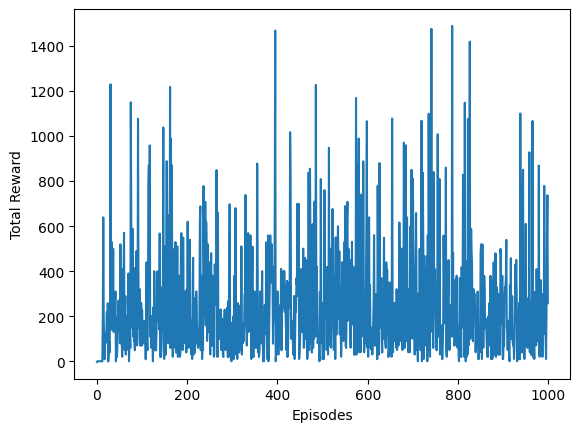

Converged Q Value
 [[ 88.99997191  90.           3.65880612 100.        ]
 [ 88.99546765  90.          67.16491699 100.        ]
 [ 30.97037073  60.61956283  70.32401835 100.        ]
 [  0.           0.           0.           0.        ]]


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def q_learning_td(transitions, rewards, gamma, alpha, epsilon, n_episodes):
    n_states, n_actions, _ = transitions.shape
    q_table = np.zeros((n_states, n_actions))
    
    total_rewards = []
    for episode in range(n_episodes):
        state = 0
        done = False
        total_reward = 0
        while not done:
            if np.random.rand()<epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(q_table[state])
            new_state = np.random.choice(np.arange(n_states), p=transitions[state, action]/np.sum(transitions[state, action]))
            reward = rewards[state, action]
            td_target = reward + gamma * np.max(q_table[new_state])
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error
            state = new_state
            total_reward += reward
            if state == n_states-1:
                done = True
        total_rewards.append(total_reward)
    
    plt.plot(total_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.show()
    
    return q_table

# Example usage
gamma = 0.9
alpha = 0.5
epsilon = 0.1
n_episodes = 1000

# Assuming transitions and rewards are defined elsewhere
q_table = q_learning_td(transitions, rewards, gamma, alpha, epsilon, n_episodes)

# Print the converged Q values
print("Converged Q Value\n", q_table)
